In [1]:
import pandas as pd
import numpy as np
import re
import operator

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

/home/michael/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from spacy.parts_of_speech import ADV
from spacy.en import English
parser = English()

In [3]:
stopwords = ['digital','format','video','interview','analysis','technology','be','high','free']

In [4]:
players = pd.read_csv('players.csv',dtype={'Pick':str})

In [5]:
players[players['Name']=="Doug McDermott"]

,Year,Pick,Drafted,Traded to,Name,Height,Weight,College,Birthday,Comment,RSCI,Position,StandingReach,Wingspan,Vertical,Text
70,2014,1.11,Bulls,,Doug McDermott,6'8,218,Creighton,1992-01-03,,&nbsp,SF/PF,"8' 7""","6' 9.25""",36.5,Doug McDermott had one of the best statistica...


In [6]:
players['Pick'] = map(lambda x: (int(x.split('.')[0])-1)*30 + int(x.split('.')[1]), players['Pick'].astype(str))

In [7]:
players['Height'] = map(lambda x: x.strip('"'),players['Height'])

In [8]:
players = players[players['Text'].notnull()]

In [9]:
players['Text'] = map(lambda x: x.strip(' '), players['Text'])
players['Text'].replace('',np.nan,inplace=True)

In [10]:
def convert_length(length):
    '''
    Returns length in inches
    '''
    try:
        length = length.strip('"')
        length = (float(length.split("'")[0]))*12 + float(length.split("'")[1])
    except:
        pass
    return length

def convert_position(position):
    position = position.split('/')
    POSITIONS = {'C':5,'PF':4,'SF':3,'F':3,'SG':2,'PG':1,'G':1}
    for i, pos in enumerate(position):
        position[i] = POSITIONS[pos]
    return np.mean(position)

In [11]:
players['Height'] = map(convert_length, players['Height'])
players['StandingReach'] = map(convert_length, players['StandingReach'])
players['Wingspan'] = map(convert_length, players['Wingspan'])
players['Position'] = map(convert_position, players['Position'])

In [12]:
players = players[players['Text'].notnull()]

In [13]:
cleaned = players[players['Text'].notnull()]

In [14]:
cleaned.index = range(len(cleaned))

In [15]:
cleaned['Parsed'] = map(lambda x: parser(x.decode('utf-8')), cleaned['Text'])

In [193]:
def tokenize_and_stem(text):
    tokens = parser(text)
    stems = []
    for token in tokens:
        if not token.is_stop and token.is_alpha and (token.pos_=='ADJ') and token.head.is_alpha:
            stems.append(token.lemma_)
            stems.append(token.head.lemma_)
    return stems

def tokenize_and_stem_filter_parsed(text):
    tokens = text
    stems = []
    for token in tokens:
        if not token.is_stop and token.is_alpha and (token.pos_=='ADJ') and token.head.is_alpha and (token.lemma_ not in stopwords):
            stems.append(token.lemma_)
            stems.append(token.head.lemma_)
    return stems

def tokenize_and_stem_parsed(text):
    tokens = text
    stems = []
    for token in tokens:
        if not token.is_stop and token.is_alpha and (token.lemma_ not in stopwords):
            stems.append(token.lemma_)
    return stems

def tokenize_only(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]',token):
            filtered_tokens.append(token)
    return filtered_tokens


### FIND THE PLAYERS THAT SHOW A WORD MOST FREQUENTLY
def word_filter(text,word,other_word):
    tokens = text
    stems = []
    for idx, token in enumerate(tokens):
        try:
            if token.lemma_ == word and tokens[idx+1].lemma_ == other_word:
                stems.append(token.lemma_)
        except:
            pass
    return stems

def word_counter(df,word,other_word):
    counter = {}
    for i in range(len(df)):
        counter[df['Name'][i]] = len(word_filter(df['Parsed'][i],word,other_word))
    return counter

def year_counter(df,word,other_word):
    counter = {}
    for i in range(len(df)):
        counter[df['Year'][i]] = counter.get(df['Year'][i],0) + len(word_filter(df['Parsed'][i],word,other_word))
    return counter


### COUNT THE NUMBER OF WORDS THAT APPEARS IN EACH PLAYERS DESCRIPTION
def word_counts(tokens):
    counter = {}
    for word in tokens:
        if not word.is_stop and word.is_alpha and (word.pos_=='ADJ') and (word.lemma_ not in stopwords):
            counter[word.lemma_] = counter.get(word.lemma_,0) + 1
    return counter

def most_frequent(tokens,length=3):
    return dict(sorted(word_counts(tokens).iteritems(), key=operator.itemgetter(1), reverse=True)[:length])

In [17]:
most_frequent(cleaned['Parsed'][0])

{u'impressive': 6, u'interesting': 3, u'physical': 3}

In [18]:
cleaned['Frequent'] = map(lambda x: most_frequent(x,3), cleaned['Parsed'])

In [19]:
cleaned.head()

,Year,Pick,Drafted,Traded to,Name,Height,Weight,College,Birthday,Comment,RSCI,Position,StandingReach,Wingspan,Vertical,Text,Parsed,Frequent
0,2015,1,Timberwolves,,Karl Towns,84,248,Kentucky,1995-11-15,,7,4.5,109.0,87.25,36.5,A breakdown of last night's head to head match...,"(A , breakdown , of , last , night, 's , head ...","{u'interesting': 3, u'impressive': 6, u'physic..."
1,2015,2,LA Lakers,,D'Angelo Russell,77,193,Ohio State,1996-02-23,,16,1.5,102.0,81.75,NaN,A breakdown of last night's head to head match...,"(A , breakdown , of , last , night, 's , head ...","{u'heavy': 1, u'new': 2, u'elite': 2}"
2,2015,3,Philadelphia,,Jahlil Okafor,83,272,Duke,1995-12-15,,2,5.0,110.5,89.00,NaN,That isn't to say that there isn't a place for...,"(That , is, n't , to , say , that , there , is...","{u'major': 3, u'good': 4, u'old': 4}"
3,2015,4,Knicks,,Kristaps Porzingis,84,230,Sevilla,1995-08-02,,&nbsp,4.0,NaN,NaN,NaN,Mike Schmitz breaks down Kristaps Porzingis' e...,"(Mike , Schmitz , breaks , down , Kristaps , P...","{u'exclusive': 1, u'unique': 1, u'impressive': 2}"
4,2015,5,Magic,,Mario Hezonja,80,200,Barcelona,1995-02-25,,&nbsp,2.5,NaN,NaN,NaN,Analyzing the play of Mario Hezonja in Game on...,"(Analyzing , the , play , of , Mario , Hezonja...","{u'poor': 3, u'spanish': 3, u'nice': 4}"


In [20]:
# iq, crafty

In [196]:
xs = []
ys = []
for key, value in year_counter(cleaned,'mid','range').items():
#     if value > 0:
        print key,value
        xs.append(key)
        ys.append(value)

2000 0
2001 0
2002 1
2003 0
2004 0
2005 1
2006 4
2007 5
2008 2
2009 2
2010 2
2011 1
2012 0
2013 0
2014 0
2015 0


In [200]:
import seaborn as sns

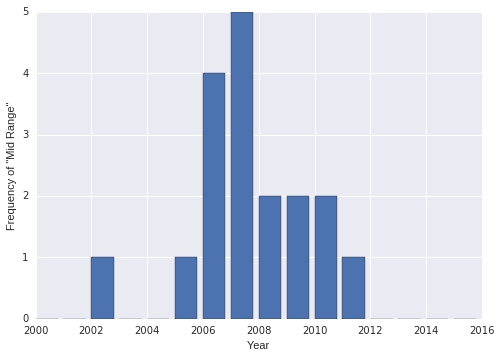

In [202]:
plt.bar(xs,ys)
plt.xlabel('Year')
plt.ylabel('Frequency of "Mid Range"')

In [22]:
tokenize_and_stem_parsed(cleaned['Parsed'][0])

[u'breakdown',
 u'night',
 u'head',
 u'head',
 u'matchup',
 u'power',
 u'forward',
 u'pick',
 u'nba',
 u'draft',
 u'karl',
 u'anthony',
 u'town',
 u'kristaps',
 u'porzingis',
 u'town',
 u'particularly',
 u'interesting',
 u'case',
 u'study',
 u'elite',
 u'prospect',
 u'era',
 u'operate',
 u'post',
 u'nba',
 u'level',
 u'flash',
 u'ability',
 u'bang',
 u'paint',
 u'hook',
 u'shot',
 u'freshman',
 u'year',
 u'shoot',
 u'touch',
 u'give',
 u'upside',
 u'finesse',
 u'scorer',
 u'midrange',
 u'like',
 u'randolph',
 u'aldridge',
 u'significantly',
 u'unlike',
 u'okafor',
 u'center',
 u'nba',
 u'point',
 u'buffer',
 u'scoring',
 u'productivity',
 u'efficiency',
 u'throw',
 u'line',
 u'shoot',
 u'spectacular',
 u'season',
 u'event',
 u'record',
 u'participate',
 u'year',
 u'nba',
 u'physically',
 u'impose',
 u'center',
 u'severely',
 u'limit',
 u'ability',
 u'game',
 u'offensively',
 u'shooting',
 u'foul',
 u'line',
 u'sink',
 u'efficiency',
 u'unacceptable',
 u'level',
 u'center',
 u'throw',
 

# SKLearn

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
vectorizer = TfidfVectorizer(min_df=2,
                             tokenizer=tokenize_and_stem_parsed,
                             preprocessor = lambda x: x,
#                              tokenizer=tokenize_only,
                             stop_words=stopwords,
                             ngram_range=(2,2))

text_cv = vectorizer.fit(cleaned['Parsed'])
text_matrix = vectorizer.fit_transform(cleaned['Parsed'])
feature_names = vectorizer.get_feature_names()

In [138]:
vectorizer = CountVectorizer(min_df=2,
                             max_df=.95,
                             tokenizer=tokenize_and_stem_parsed,
                             preprocessor = lambda x: x,
#                              tokenizer=tokenize_only,
                             stop_words=stopwords,
                             ngram_range=(2,2))

text_cv = vectorizer.fit(cleaned['Parsed'])
text_matrix = vectorizer.fit_transform(cleaned['Parsed'])
feature_names = vectorizer.get_feature_names()

### LDA

In [139]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [140]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [141]:
import lda

In [142]:
model = lda.LDA(n_topics=3, n_iter=500, random_state=1)
model.fit(text_matrix)  # model.fit_transform(X) is also available

<lda.lda.LDA instance at 0x7feb77d061b8>

(array([ 129.,  171.,  134.,  123.,   96.,   58.,   31.,   13.,    3.,    3.]),
 array([  9.56663159e-05,   9.96346324e-02,   1.99173599e-01,
          2.98712565e-01,   3.98251531e-01,   4.97790497e-01,
          5.97329463e-01,   6.96868429e-01,   7.96407395e-01,
          8.95946361e-01,   9.95485327e-01]),
 <a list of 10 Patch objects>)

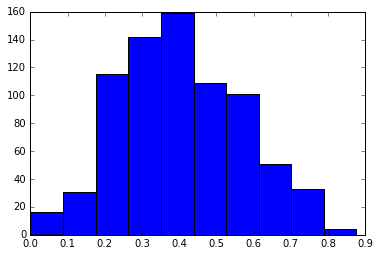

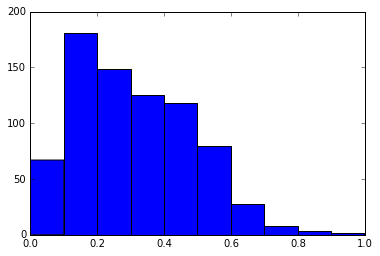

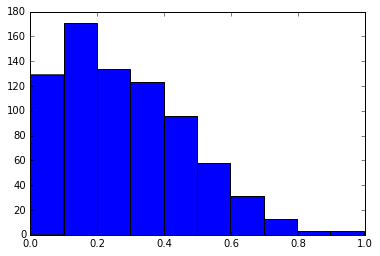

In [143]:
%matplotlib inline 
plt.hist(model.doc_topic_[:,0])
plt.figure()

plt.hist(model.doc_topic_[:,1])
plt.figure()

plt.hist(model.doc_topic_[:,2])

In [144]:
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(feature_names)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: jump shot lateral quickness good job defensive end physical tool small forward throw line pick roll
Topic 1: point guard ball handling half court mid range handling skill ncaa tournament create shot court vision
Topic 2: big man point rebound power forward mid range block shot look like low post year old


In [145]:
model.doc_topic_.shape

(761, 3)

In [146]:
topic = []
for row in model.doc_topic_:
    topic.append(row.argmax())

### KMEANS

In [37]:
from sklearn.cluster import KMeans

In [38]:
from sklearn.preprocessing import normalize
text_matrix = normalize(text_matrix.toarray())

/home/michael/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [39]:
km = KMeans(n_clusters=3)

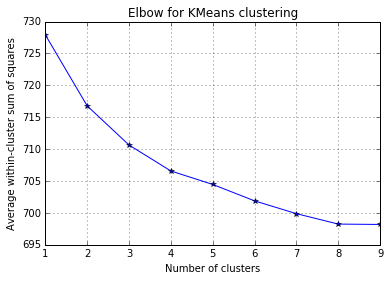

In [40]:
def plot_kmeans(data):
    tfidf = TfidfVectorizer(min_df=.01, ngram_range=(1,2))
    X = data

    ##### cluster data into K=1..10 clusters #####
    K = range(1,10)

    # scipy kmeans module for each value of k:
    KM = [KMeans(n_clusters=k).fit(X) for k in K]
    ##list comprehension to cluster centroids
    inertia = [model.inertia_ for model in KM]

#     # alternative: scipy.spatial.distance.cdist
#     D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
#     cIdx = [np.argmin(D,axis=1) for D in D_k]
#     dist = [np.min(D,axis=1) for D in D_k]
#     avgWithinSS = [sum(d)/X.shape[0] for d in dist]

#     ##### plot ###
    kIdx = 4

    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, inertia, 'b*-')
#     ax.plot(K[kIdx], avgWithinSS[kIdx], marker='x', markersize=12, 
#         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')

    
plot_kmeans(text_matrix)

In [41]:
km.fit(text_matrix)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [42]:
clusters = km.labels_.tolist()

### Analyze

In [147]:
clustered = {'Name':cleaned['Name'],
             'Year':cleaned['Year'],
             'Position':cleaned['Position'],
             'Height':cleaned['Height'],
             'Weight':cleaned['Weight'],
             'Pick':cleaned['Pick'],
             'Vertical':cleaned['Vertical'],
             'Cluster':clusters,
             'Topic':topic,
             'Frequent':cleaned['Frequent']}

In [148]:
frame = pd.DataFrame(clustered,columns = ['Name',
                                          'Year',
                                          'Position', 
                                          'Height', 
                                          'Weight',
                                          'Pick',
                                          'Vertical',
                                          'Cluster',
                                          'Topic', 
                                          'Frequent'])

In [149]:
name_dict = {0:'zero',1:'one',2:'two',3:'three'}
names = map(lambda x: name_dict[x], clusters)

In [150]:
name_dict = {0:'zero',1:'one',2:'two',3:'three'}
names = map(lambda x: name_dict[x], topic)

In [151]:
test_d = {'Cluster':names,
          'ClusterNum':topic,
          'Year':cleaned['Year'],
          'Position':cleaned['Position'],
          'Pick':cleaned['Pick'],
          'Height':cleaned['Height'],
          'Weight':cleaned['Weight']
       }
test = pd.DataFrame(test_d,columns = ['Cluster',
                                      'ClusterNum',
                                      'Year',
                                      'Position',
                                      'Pick',
                                      'Height',
                                      'Weight'])
test = test[test['Weight']>'100']
test.to_csv('parallel/test.csv',index=False)

In [152]:
cleaned.head()

,Year,Pick,Drafted,Traded to,Name,Height,Weight,College,Birthday,Comment,RSCI,Position,StandingReach,Wingspan,Vertical,Text,Parsed,Frequent
0,2015,1,Timberwolves,,Karl Towns,84,248,Kentucky,1995-11-15,,7,4.5,109.0,87.25,36.5,A breakdown of last night's head to head match...,"(A , breakdown , of , last , night, 's , head ...","{u'interesting': 3, u'impressive': 6, u'physic..."
1,2015,2,LA Lakers,,D'Angelo Russell,77,193,Ohio State,1996-02-23,,16,1.5,102.0,81.75,NaN,A breakdown of last night's head to head match...,"(A , breakdown , of , last , night, 's , head ...","{u'heavy': 1, u'new': 2, u'elite': 2}"
2,2015,3,Philadelphia,,Jahlil Okafor,83,272,Duke,1995-12-15,,2,5.0,110.5,89.00,NaN,That isn't to say that there isn't a place for...,"(That , is, n't , to , say , that , there , is...","{u'major': 3, u'good': 4, u'old': 4}"
3,2015,4,Knicks,,Kristaps Porzingis,84,230,Sevilla,1995-08-02,,&nbsp,4.0,NaN,NaN,NaN,Mike Schmitz breaks down Kristaps Porzingis' e...,"(Mike , Schmitz , breaks , down , Kristaps , P...","{u'exclusive': 1, u'unique': 1, u'impressive': 2}"
4,2015,5,Magic,,Mario Hezonja,80,200,Barcelona,1995-02-25,,&nbsp,2.5,NaN,NaN,NaN,Analyzing the play of Mario Hezonja in Game on...,"(Analyzing , the , play , of , Mario , Hezonja...","{u'poor': 3, u'spanish': 3, u'nice': 4}"


In [153]:
frame['Cluster'].value_counts()

2    412
0    224
1    125
Name: Cluster, dtype: int64

In [154]:
frame.head()

,Name,Year,Position,Height,Weight,Pick,Vertical,Cluster,Topic,Frequent
0,Karl Towns,2015,4.5,84,248,1,36.5,2,2,"{u'interesting': 3, u'impressive': 6, u'physic..."
1,D'Angelo Russell,2015,1.5,77,193,2,NaN,2,2,"{u'heavy': 1, u'new': 2, u'elite': 2}"
2,Jahlil Okafor,2015,5.0,83,272,3,NaN,2,2,"{u'major': 3, u'good': 4, u'old': 4}"
3,Kristaps Porzingis,2015,4.0,84,230,4,NaN,2,2,"{u'exclusive': 1, u'unique': 1, u'impressive': 2}"
4,Mario Hezonja,2015,2.5,80,200,5,NaN,2,2,"{u'poor': 3, u'spanish': 3, u'nice': 4}"


In [155]:
frame.to_csv('cleaned.csv')

In [156]:
frame['Topic'].value_counts()

0    351
1    216
2    194
Name: Topic, dtype: int64

Cluster
0    [[Axes(0.125,0.684722;0.336957x0.215278), Axes...
1    [[Axes(0.125,0.684722;0.336957x0.215278), Axes...
2    [[Axes(0.125,0.684722;0.336957x0.215278), Axes...
dtype: object

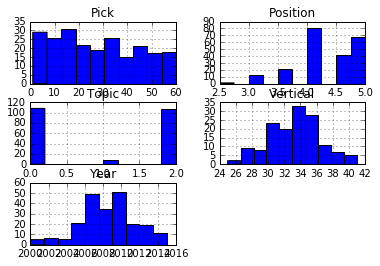

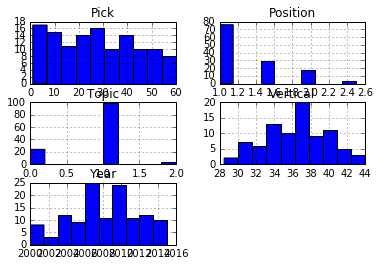

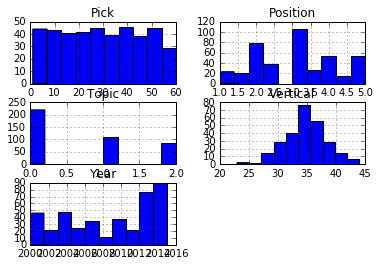

In [157]:
frame.groupby('Cluster').hist()

In [158]:
order_centroids = km.cluster_centers_ > .02

In [159]:
feature_names = np.array(feature_names)

In [160]:
def print_knn_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.cluster_centers_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [161]:
km.inertia_

710.61955669515987

In [162]:
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances

In [163]:
closest, dist = pairwise_distances_argmin_min(km.cluster_centers_,text_matrix,metric='euclidean')

In [164]:
cluster_dist = pairwise_distances(km.cluster_centers_,km.cluster_centers_,metric='euclidean')

In [165]:
cluster_dist

array([[ 0.        ,  0.37792741,  0.20551173],
       [ 0.37792741,  0.        ,  0.31992795],
       [ 0.20551173,  0.31992795,  0.        ]])

In [166]:
closest

array([259, 259, 259])

In [167]:
frame.loc[[451]]

,Name,Year,Position,Height,Weight,Pick,Vertical,Cluster,Topic,Frequent
451,Acie Law,2007,1,76,186,11,34,1,1,"{u'good': 12, u'mid': 11, u'nice': 11}"


In [168]:
frame.groupby('Cluster')['Position'].value_counts()[3]

21

In [76]:
np.arange(1,5.1,.5)

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

In [102]:
np.arange(2000,2015.1,1)

array([ 2000.,  2001.,  2002.,  2003.,  2004.,  2005.,  2006.,  2007.,
        2008.,  2009.,  2010.,  2011.,  2012.,  2013.,  2014.,  2015.])

In [103]:
def group_to_array(data,cluster):
    a = []
    d = {}
    for i in range(cluster):
        for position in np.arange(2000,2015.1,1):
            d['position'] = position
            try:
                d['value'] = data[i][position]
            except:
                d['value'] = 0
            d['topic'] = i
            a.append(d)
            d={}
    return a

In [104]:
frame.groupby('Topic')['Year'].value_counts()

Topic  Year
0      2014    41
       2010    36
       2012    35
       2011    31
       2013    25
       2003    24
       2002    23
       2004    23
       2001    21
       2009    20
       2000    19
       2005    17
       2015    14
       2008    10
       2006     6
       2007     6
1      2007    28
       2009    26
       2006    23
       2008    22
       2013    19
       2005    18
       2011    14
       2012    13
       2015    13
       2010    12
       2014    10
       2004     7
       2000     4
       2001     3
       2003     3
       2002     1
2      2015    28
       2008    26
       2007    24
       2006    22
       2005    20
       2009    10
       2010     9
       2013     9
       2011     8
       2001     7
       2002     7
       2012     7
       2000     5
       2003     5
       2014     4
       2004     3
dtype: int64

In [105]:
group_to_array(frame.groupby('Topic')['Year'].value_counts(),3)

/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point


[{'position': 2000.0, 'topic': 0, 'value': 19},
 {'position': 2001.0, 'topic': 0, 'value': 21},
 {'position': 2002.0, 'topic': 0, 'value': 23},
 {'position': 2003.0, 'topic': 0, 'value': 24},
 {'position': 2004.0, 'topic': 0, 'value': 23},
 {'position': 2005.0, 'topic': 0, 'value': 17},
 {'position': 2006.0, 'topic': 0, 'value': 6},
 {'position': 2007.0, 'topic': 0, 'value': 6},
 {'position': 2008.0, 'topic': 0, 'value': 10},
 {'position': 2009.0, 'topic': 0, 'value': 20},
 {'position': 2010.0, 'topic': 0, 'value': 36},
 {'position': 2011.0, 'topic': 0, 'value': 31},
 {'position': 2012.0, 'topic': 0, 'value': 35},
 {'position': 2013.0, 'topic': 0, 'value': 25},
 {'position': 2014.0, 'topic': 0, 'value': 41},
 {'position': 2015.0, 'topic': 0, 'value': 14},
 {'position': 2000.0, 'topic': 1, 'value': 4},
 {'position': 2001.0, 'topic': 1, 'value': 3},
 {'position': 2002.0, 'topic': 1, 'value': 1},
 {'position': 2003.0, 'topic': 1, 'value': 3},
 {'position': 2004.0, 'topic': 1, 'value': 7},

In [80]:
frame.groupby('Cluster')['Position'].value_counts()[0]

Position
4.0    81
5.0    68
4.5    41
3.5    21
3.0    12
2.5     1
dtype: int64

# Viz

In [59]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(text_matrix)

In [60]:

import os  # for os.path.basename

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [60]:

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

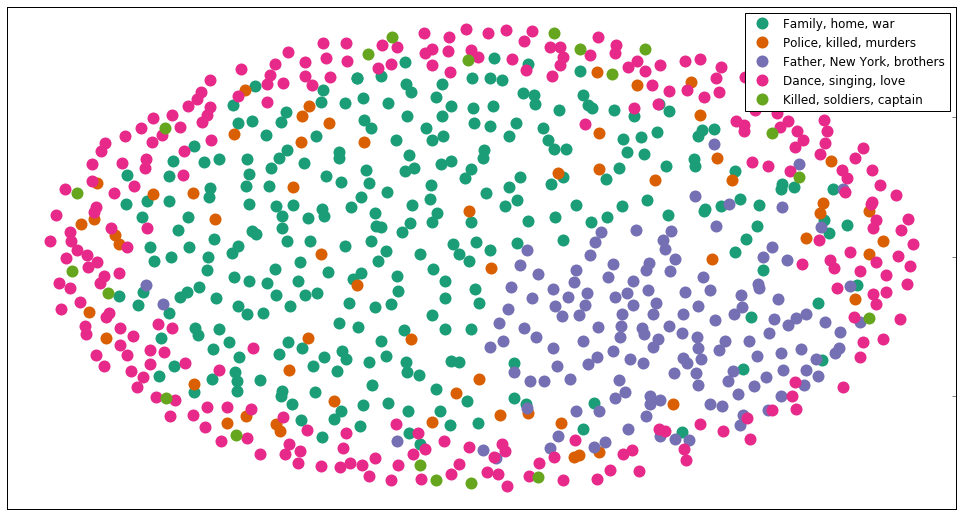

In [61]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=frame['Cluster'], title=frame['Name']),index=range(len(frame))) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [63]:
import seaborn as sns

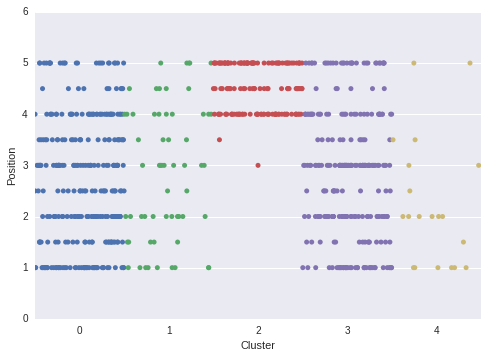

In [64]:
sns.stripplot(frame['Cluster'],frame['Position'],jitter=.5)

In [66]:
frame.head()

,Name,Position,Cluster,Topic,Pick,Vertical
0,Karl Towns,4.5,1,1,1,36.5
1,D'Angelo Russell,1.5,1,0,2,NaN
2,Jahlil Okafor,5.0,2,1,3,NaN
3,Kristaps Porzingis,4.0,3,1,4,NaN
4,Mario Hezonja,2.5,3,1,5,NaN


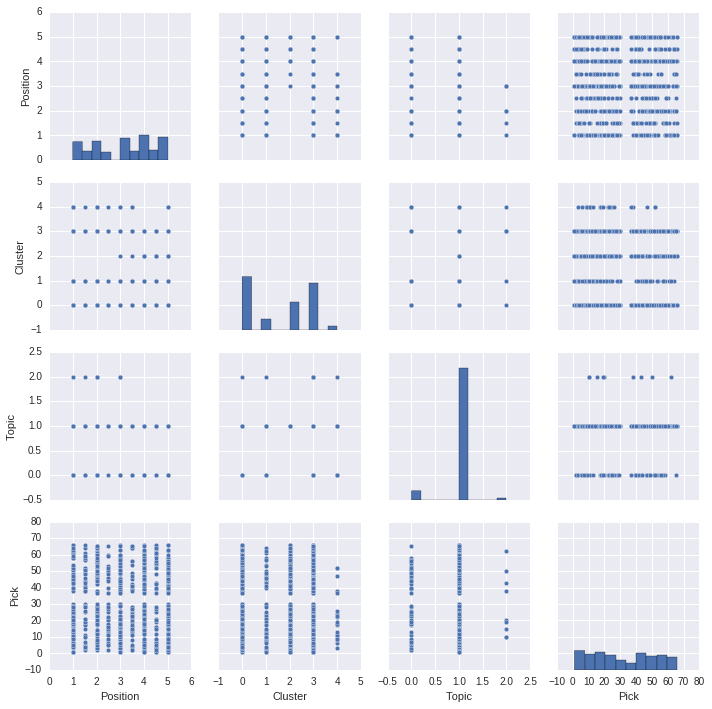

In [76]:
sns.pairplot(frame[['Position','Cluster','Topic','Pick']],dropna=True)

# LDA

In [124]:
import logging, gensim, bz2

In [1]:
vector_

NameError: name 'vector_' is not defined